In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install shap
import cv2
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import shap
import random
import seaborn as sns
import h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 30.2 MB/s eta 0:00:00


In [4]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [5]:
x_train = [] # training images
y_train = [] # training labels
x_test = []  # testing images
y_test = []  # testing labels

#image_size = 200

In [6]:
extracted_dir_path = '/content/drive/MyDrive/archive'
print("Contents of the extracted directory:")
print(os.listdir(extracted_dir_path))




Contents of the extracted directory:
['preprocessed_training', 'Testing', 'preprocessed_testing', 'Training']


In [7]:
train_dir = os.path.join(extracted_dir_path, 'Training')
test_dir = os.path.join(extracted_dir_path, 'Testing')

print("Contents of the Training directory:")
print(os.listdir(train_dir))

print("\nContents of the Testing directory:")
print(os.listdir(test_dir))

Contents of the Training directory:
['glioma', 'meningioma', 'notumor', 'pituitary']

Contents of the Testing directory:
['meningioma', 'glioma', 'notumor', 'pituitary']


Training Data:
Displaying images for label: glioma


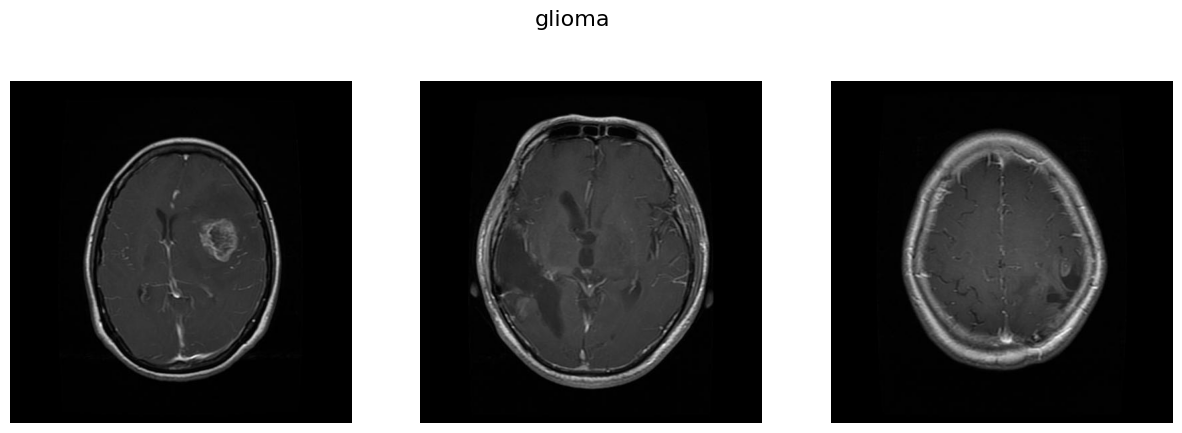

Displaying images for label: meningioma


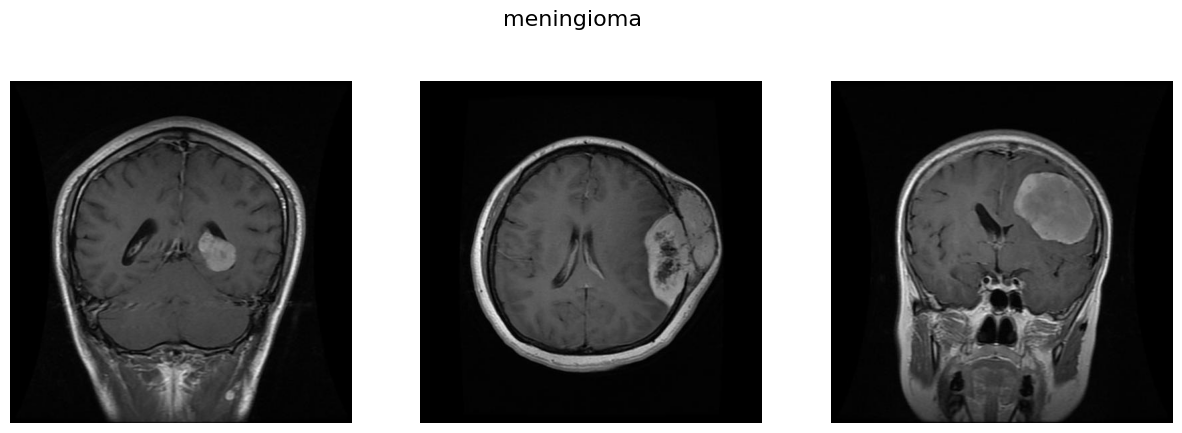

Displaying images for label: notumor


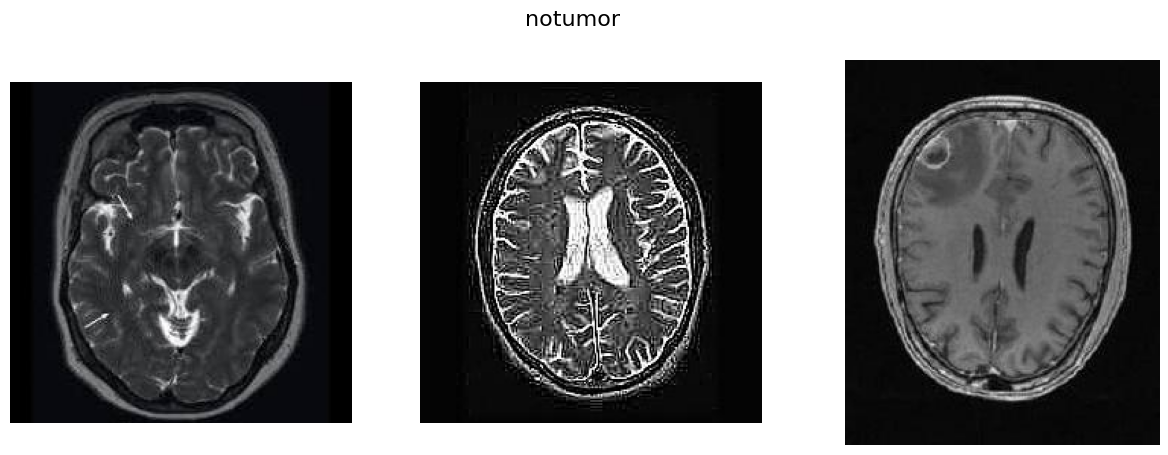

Displaying images for label: pituitary


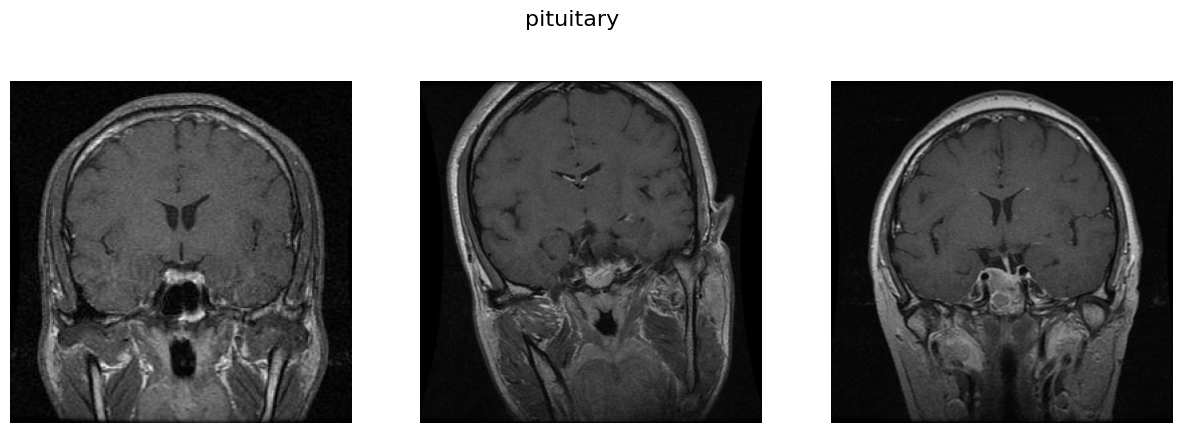

In [8]:
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob

def display_images_from_folder(data_dir, labels, num_images=3):
    """
    Display a specified number of images from each folder in the data directory.
    """
    for label in labels:
        print(f"Displaying images for label: {label}")
        label_dir = os.path.join(data_dir, label)
        images = glob(os.path.join(label_dir, '*.jpg'))

        # Plotting the images
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        fig.suptitle(label, fontsize=16)

        for i in range(num_images):
            img_path = images[i]
            img = cv2.imread(img_path)
            if img is not None:
                axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axes[i].axis('off')

        plt.show()


# Displaying images from training data
print("Training Data:")
display_images_from_folder(train_dir, labels, num_images=3)





Testing Data:
Displaying images for label: glioma


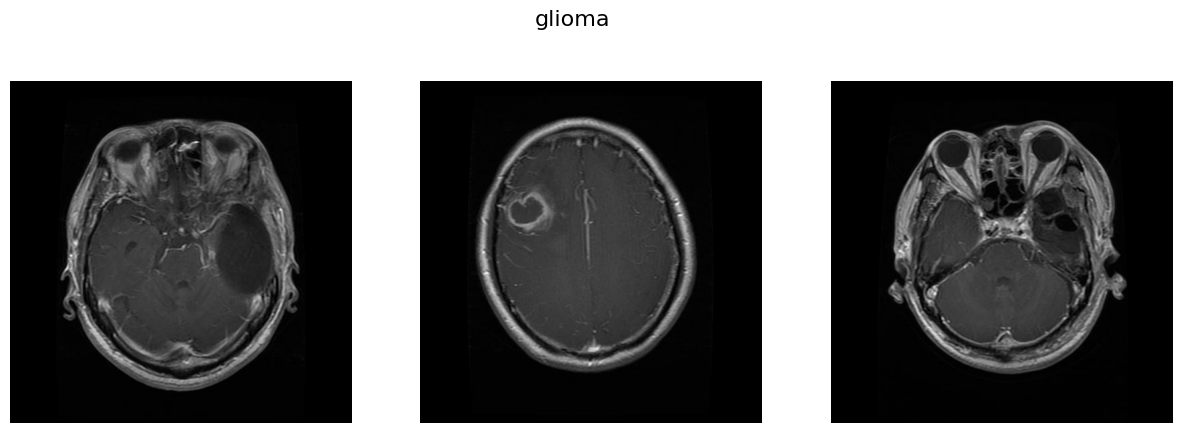

Displaying images for label: meningioma


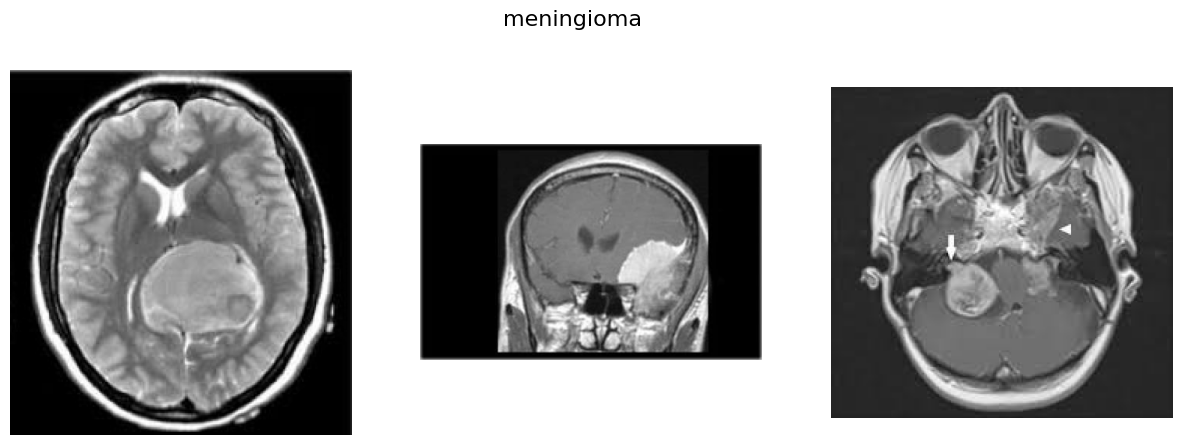

Displaying images for label: notumor


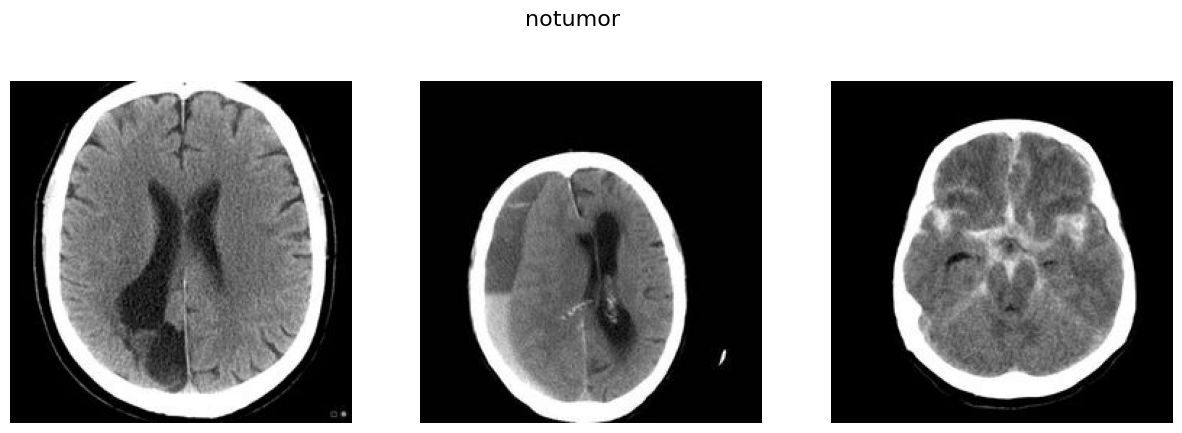

Displaying images for label: pituitary


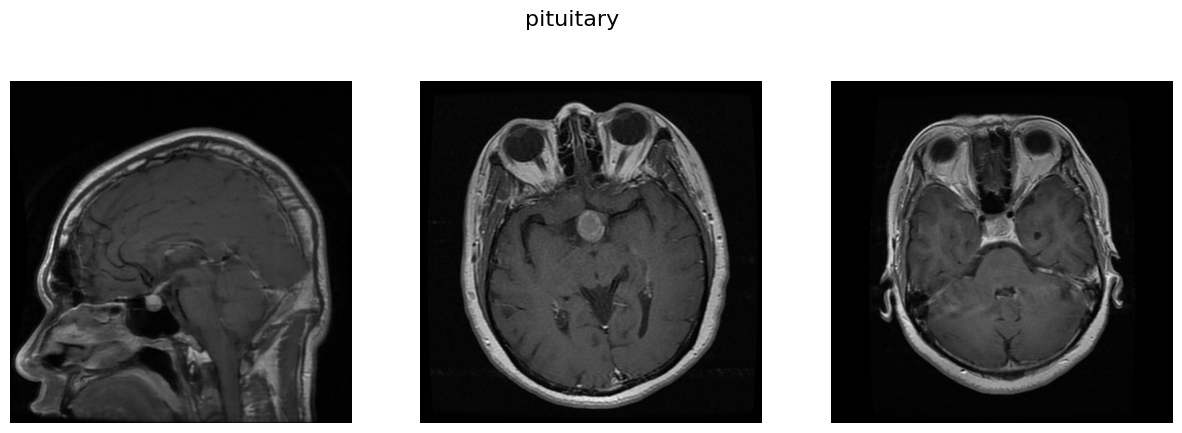

In [9]:
# Display images from testing data
print("Testing Data:")
display_images_from_folder(test_dir, labels, num_images=3)

In [10]:
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob

def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular out of them.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # threshold the image, then perform a series of erosions and dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key=cv2.contourArea)

    # get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(c)
    new_img = img[y:y+h, x:x+w].copy()

    return new_img

def preprocess_images(data_dir, output_dir, img_size=(224, 224)):
    """
    Preprocess the images by cropping and resizing them.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            output_class_dir = os.path.join(output_dir, class_dir)
            if not os.path.exists(output_class_dir):
                os.makedirs(output_class_dir)
            for img_path in tqdm(glob(os.path.join(class_path, '*.jpg'))):
                img = cv2.imread(img_path)
                if img is not None:
                    cropped_img = crop_img(img)
                    resized_img = cv2.resize(cropped_img, img_size)
                    output_img_path = os.path.join(output_class_dir, os.path.basename(img_path))
                    cv2.imwrite(output_img_path, resized_img)





In [11]:
output_train_dir = '/content/drive/MyDrive/archive/preprocessed_training'
output_test_dir = '/content/drive/MyDrive/archive/preprocessed_testing'

preprocess_images(train_dir, output_train_dir)
preprocess_images(test_dir, output_test_dir)

100%|██████████| 300/300 [03:51<00:00,  1.29it/s]


Training Data:
Displaying images for label: glioma


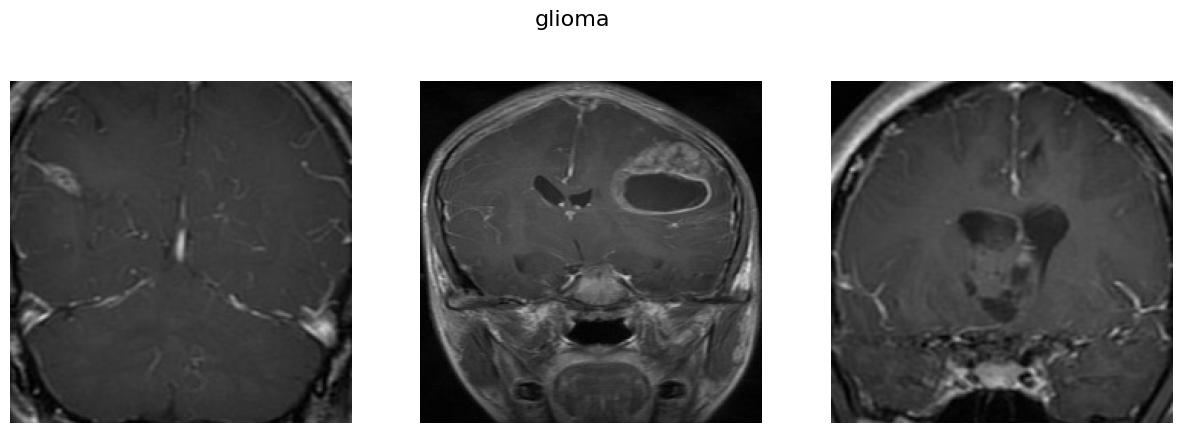

Displaying images for label: meningioma


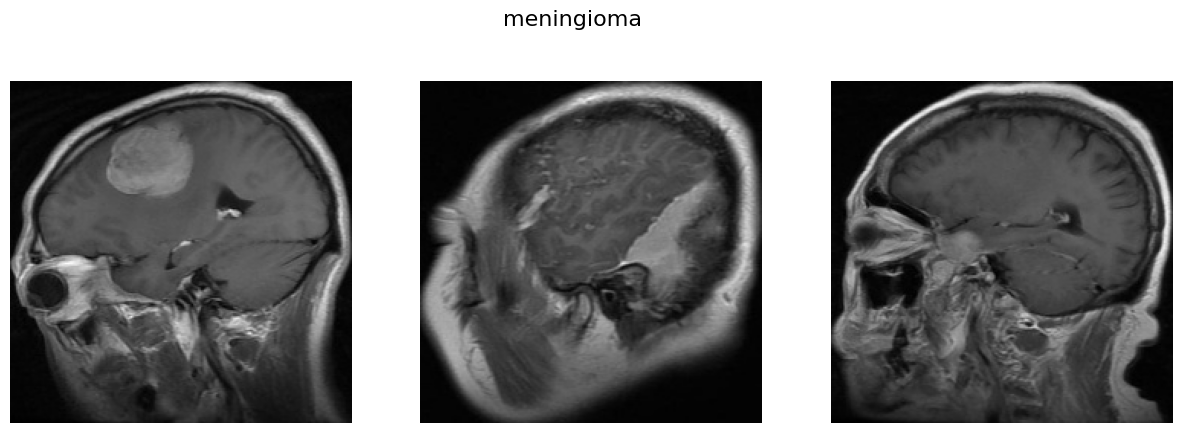

Displaying images for label: notumor


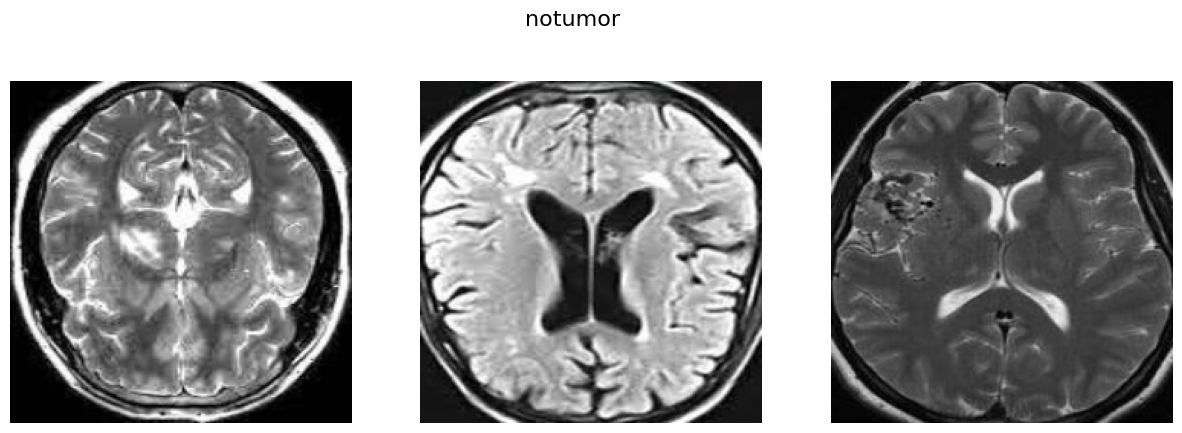

Displaying images for label: pituitary


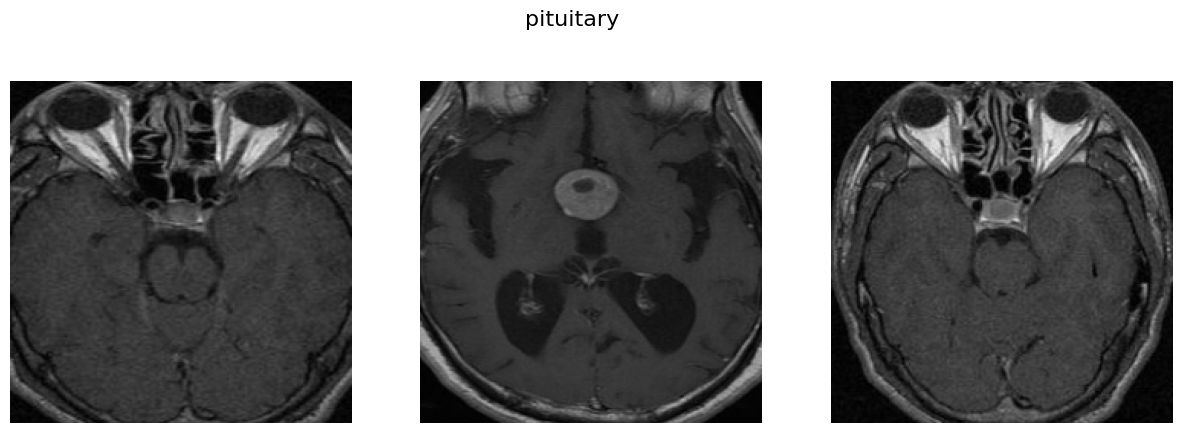

In [12]:
print("Training Data:")
display_images_from_folder(output_train_dir, labels, num_images=3)

Testing Data:
Displaying images for label: glioma


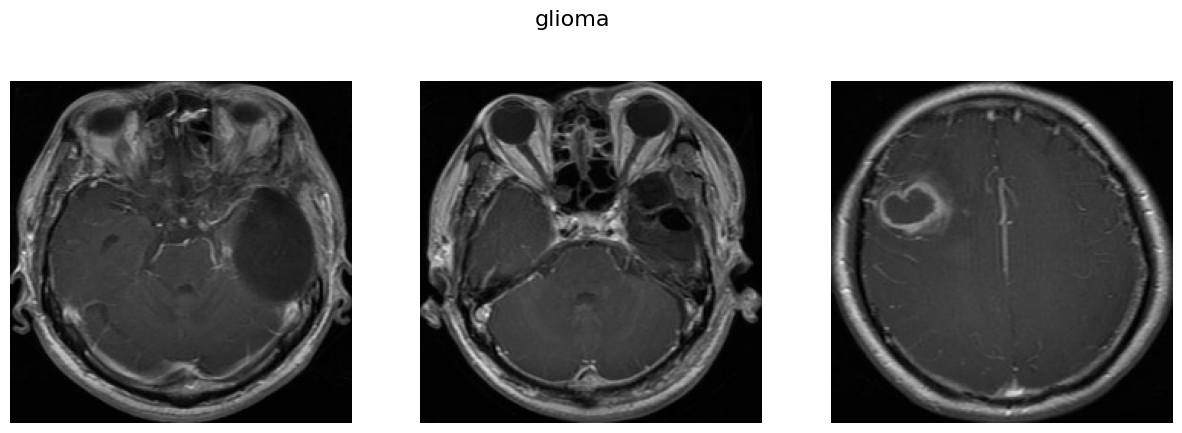

Displaying images for label: meningioma


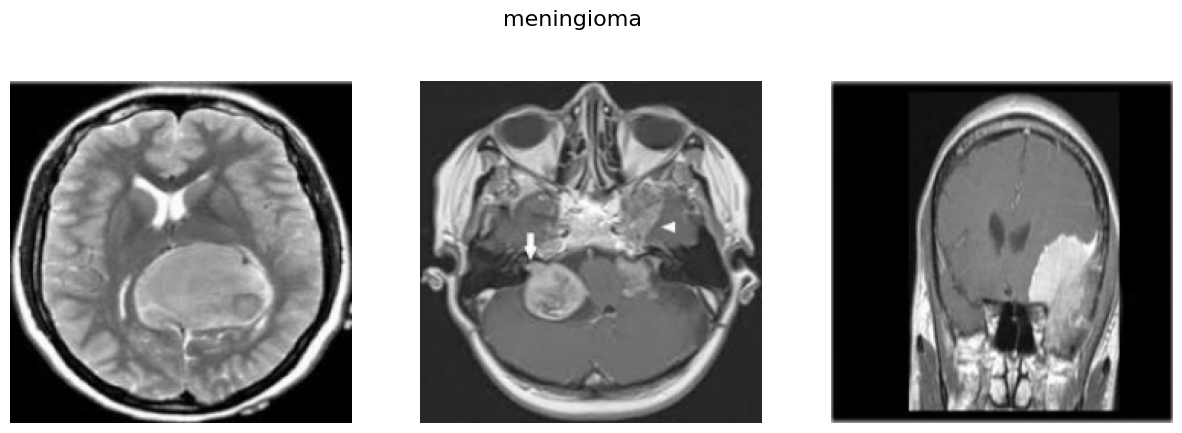

Displaying images for label: notumor


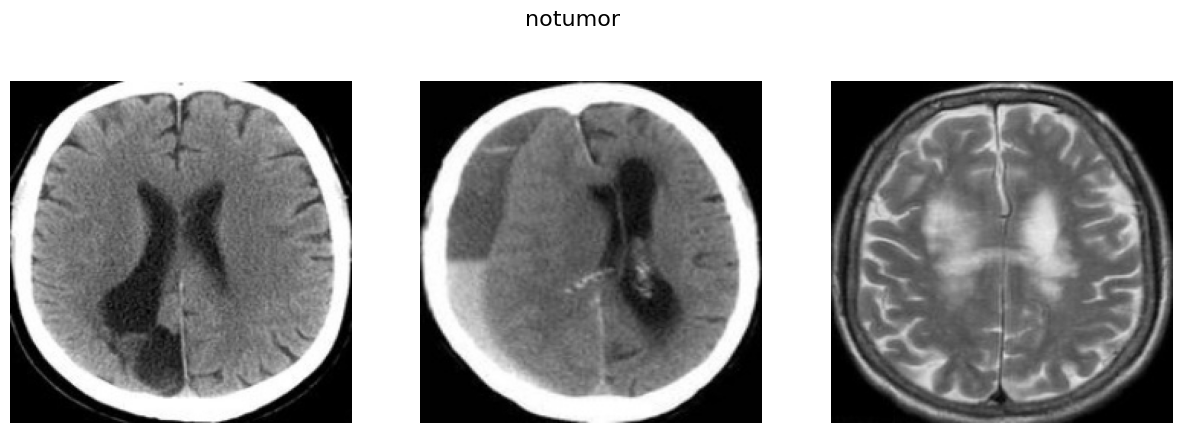

Displaying images for label: pituitary


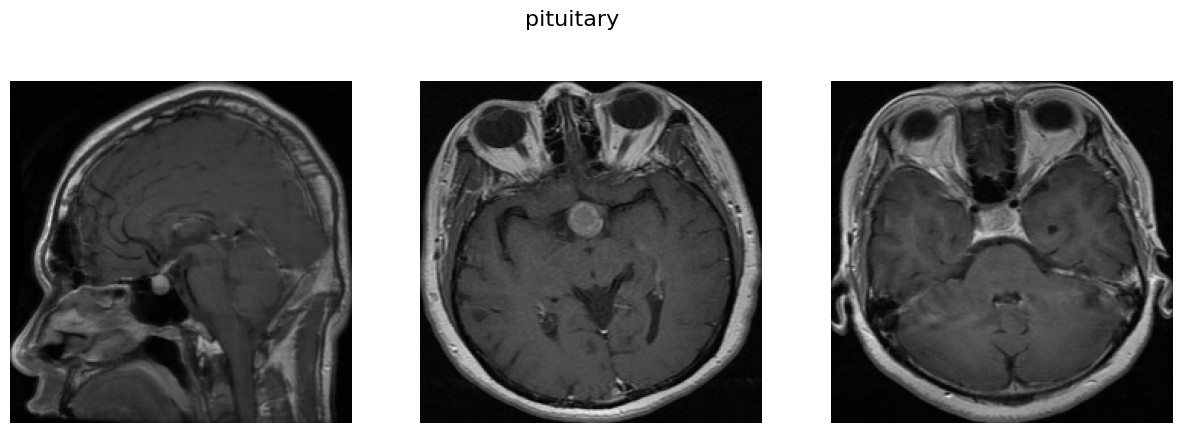

In [13]:
print("Testing Data:")
display_images_from_folder(output_test_dir, labels, num_images=3)

In [14]:
def display_images_side_by_side(original_dir, preprocessed_dir, labels):
    """
    Display original and preprocessed images side by side.
    """
    for label in labels:
        print(f"Displaying images for label: {label}")

        orig_img_path = glob(os.path.join(original_dir, label, '*.jpg'))[0]
        prep_img_path = glob(os.path.join(preprocessed_dir, label, '*.jpg'))[0]

        print(f"Original image path: {orig_img_path}")
        print(f"Preprocessed image path: {prep_img_path}")

        orig_img = cv2.imread(orig_img_path)
        prep_img = cv2.imread(prep_img_path)

        if orig_img is None:
            print(f"Error loading original image from {orig_img_path}")
            continue

        if prep_img is None:
            print(f"Error loading preprocessed image from {prep_img_path}")
            continue

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f'Original {label}')
        axes[0].axis('off')

        axes[1].imshow(cv2.cvtColor(prep_img, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'Preprocessed {label}')
        axes[1].axis('off')

        plt.show()

Displaying images for label: glioma
Original image path: /content/drive/MyDrive/archive/Training/glioma/Tr-gl_0316.jpg
Preprocessed image path: /content/drive/MyDrive/archive/preprocessed_training/glioma/Tr-gl_0647.jpg


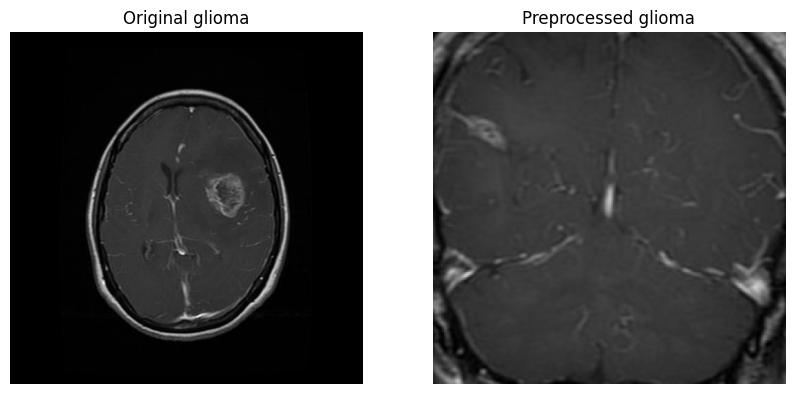

Displaying images for label: meningioma
Original image path: /content/drive/MyDrive/archive/Training/meningioma/Tr-me_0374.jpg
Preprocessed image path: /content/drive/MyDrive/archive/preprocessed_training/meningioma/Tr-me_0664.jpg


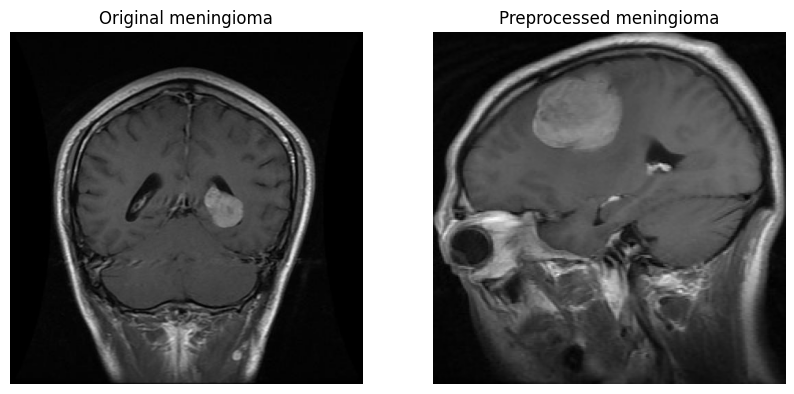

Displaying images for label: notumor
Original image path: /content/drive/MyDrive/archive/Training/notumor/Tr-no_0553.jpg
Preprocessed image path: /content/drive/MyDrive/archive/preprocessed_training/notumor/Tr-no_1210.jpg


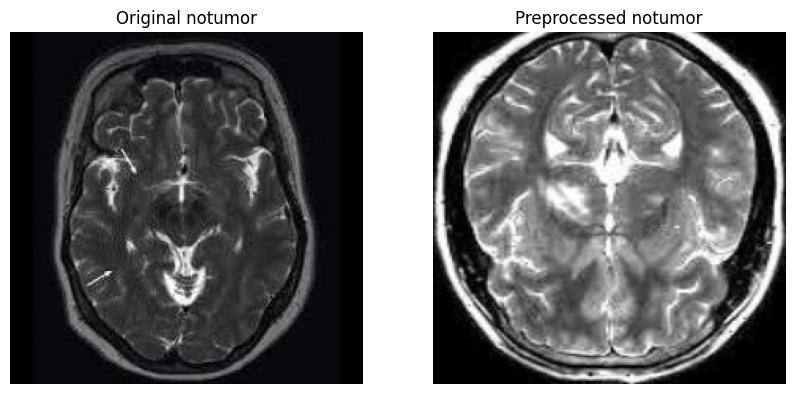

Displaying images for label: pituitary
Original image path: /content/drive/MyDrive/archive/Training/pituitary/Tr-pi_0435.jpg
Preprocessed image path: /content/drive/MyDrive/archive/preprocessed_training/pituitary/Tr-pi_0943.jpg


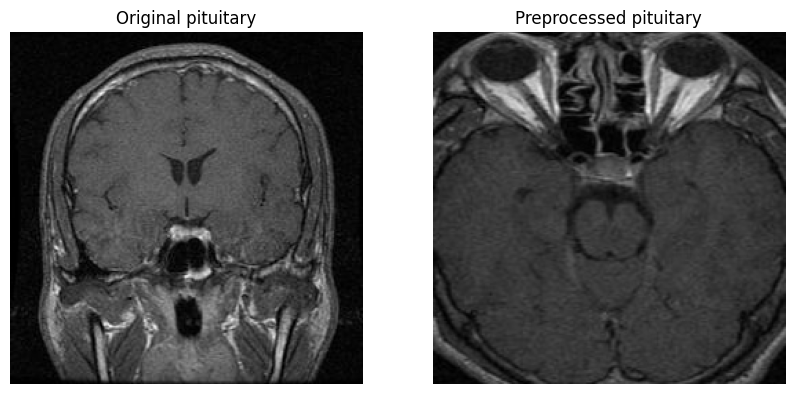

In [15]:
display_images_side_by_side(train_dir, output_train_dir, labels)

In [16]:
def plot_class_distribution(data_dir, labels, title):
    """
    Plots the class distribution for the given data directory.
    """
    class_counts = {label: len(os.listdir(os.path.join(data_dir, label))) for label in labels}

    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.show()

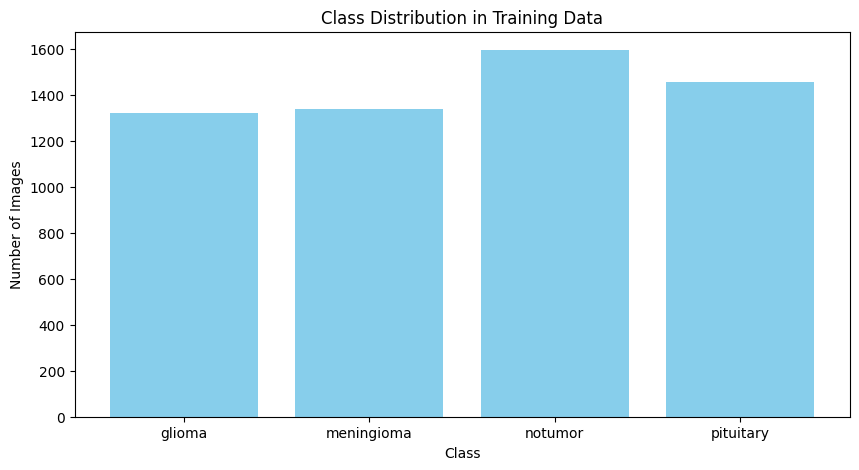

In [17]:
plot_class_distribution(output_train_dir, labels, 'Class Distribution in Training Data')

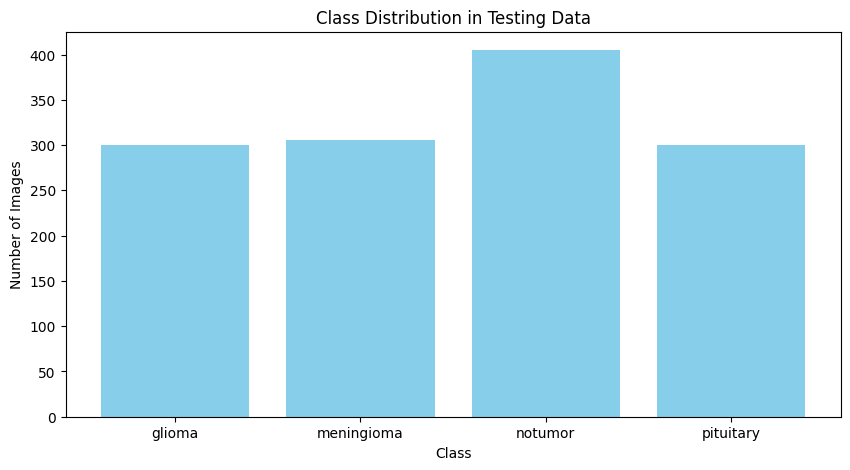

In [18]:
plot_class_distribution(output_test_dir, labels, 'Class Distribution in Testing Data')

In [19]:
def get_image_dimensions(data_dir, labels):
    """
    Returns the dimensions of images in the given data directory.
    """
    dimensions = []

    for label in labels:
        label_dir = os.path.join(data_dir, label)
        for img_path in glob(os.path.join(label_dir, '*.jpg')):
            img = cv2.imread(img_path)
            if img is not None:
                dimensions.append(img.shape[:2])  # height, width

    return dimensions


def plot_image_dimensions(dimensions, title):
    """
    Plots the distribution of image dimensions.
    """
    heights, widths = zip(*dimensions)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(heights, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    plt.title(f'{title}: Image Heights')

    plt.subplot(1, 2, 2)
    plt.hist(widths, bins=20, color='lightcoral', edgecolor='black')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    plt.title(f'{title}: Image Widths')

    plt.tight_layout()
    plt.show()

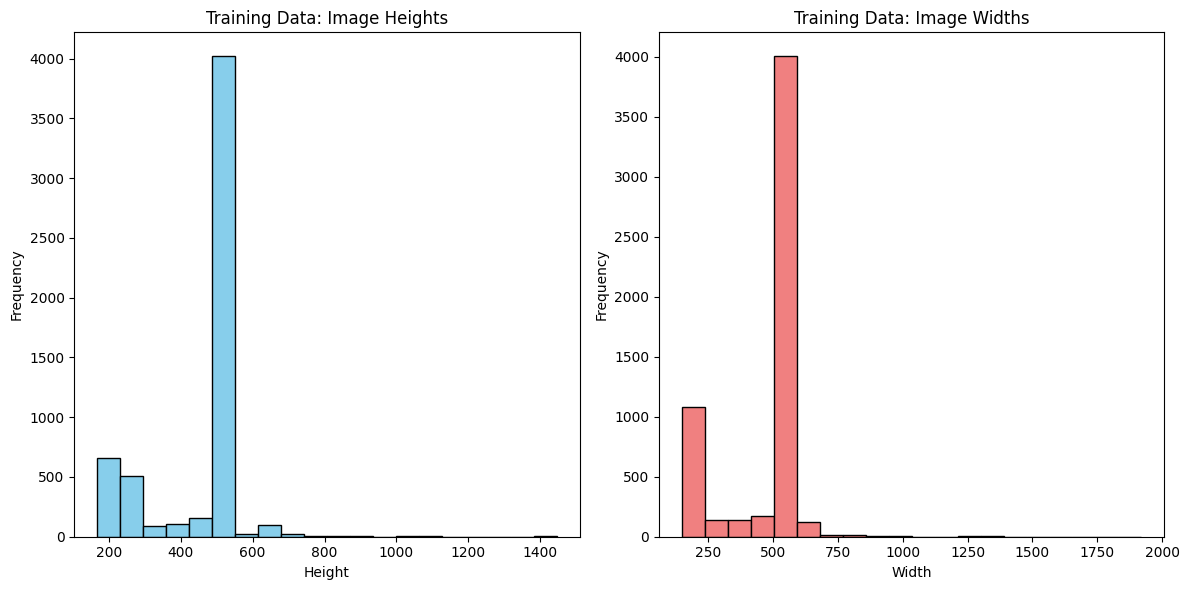

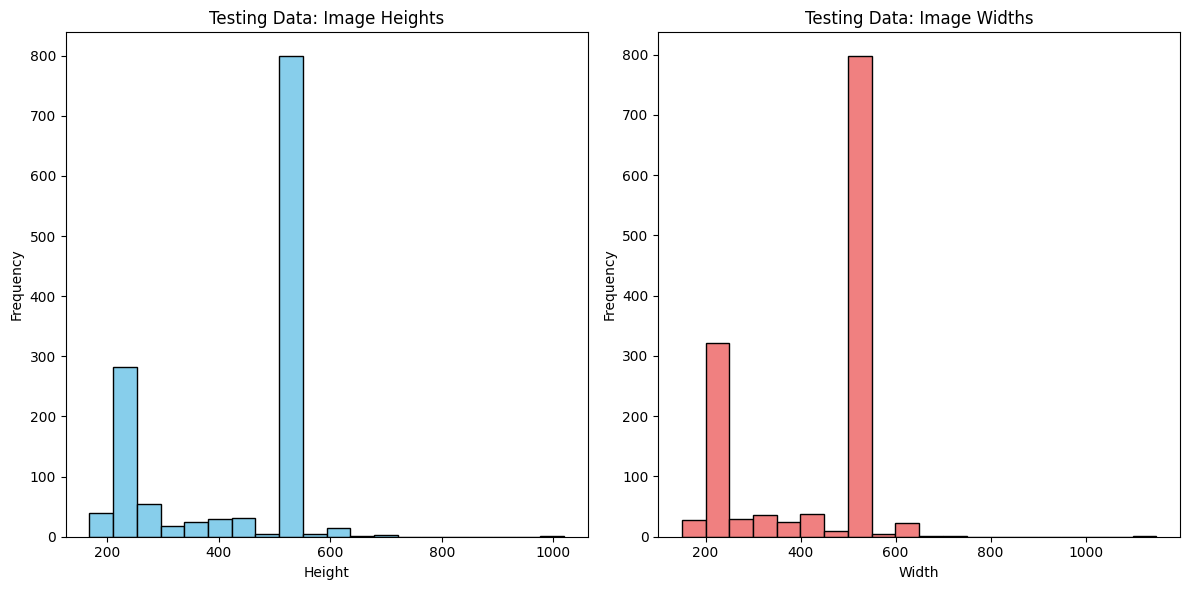

In [20]:
train_dimensions_before_processing = get_image_dimensions(train_dir, labels)
test_dimensions_before_processing = get_image_dimensions(test_dir, labels)

plot_image_dimensions(train_dimensions_before_processing, 'Training Data')
plot_image_dimensions(test_dimensions_before_processing, 'Testing Data')

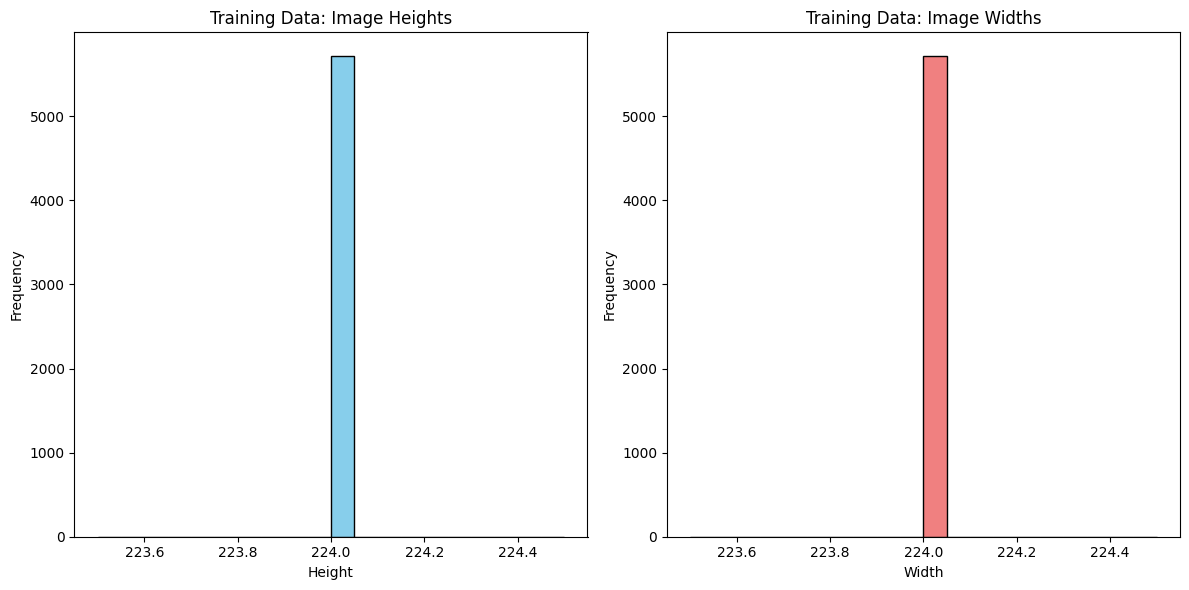

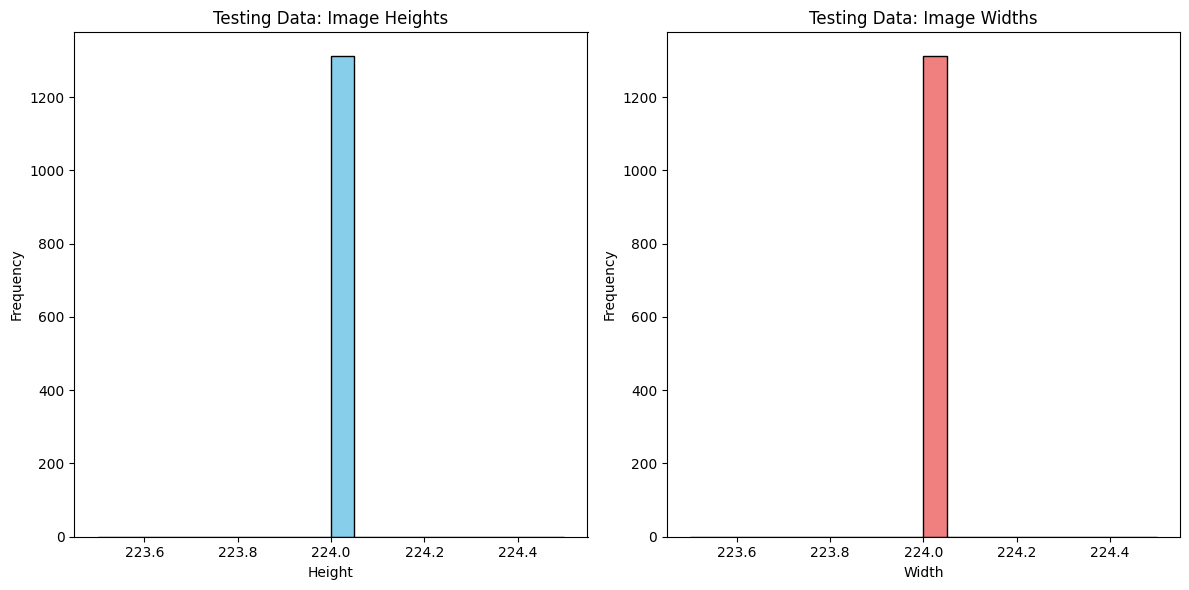

In [21]:
train_dimensions = get_image_dimensions(output_train_dir, labels)
test_dimensions = get_image_dimensions(output_test_dir, labels)

plot_image_dimensions(train_dimensions, 'Training Data')
plot_image_dimensions(test_dimensions, 'Testing Data')

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tempfile

def save_data_in_batches(data_dir, labels, output_dir, img_size=(224, 224), batch_size=50):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    def data_generator():
        for label in labels:
            label_index = labels.index(label)
            path = os.path.join(data_dir, label)
            image_files = os.listdir(path)
            for i in range(0, len(image_files), batch_size):
                batch_files = image_files[i:i+batch_size]
                images = []
                image_labels = []
                for img_file in batch_files:
                    img_path = os.path.join(path, img_file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        images.append(img)
                        image_labels.append(label_index)
                images = np.array(images) / 255.0
                image_labels = to_categorical(image_labels, num_classes=len(labels))
                yield images, image_labels

    batch_num = 0
    for images, image_labels in data_generator():
        np.savez_compressed(os.path.join(output_dir, f'batch_{batch_num}.npz'), images=images, labels=image_labels)
        batch_num += 1

In [26]:
# Loading the preprocessed training and testing data


output_dir = '/content/drive/MyDrive/archive/preprocessed_training'

save_data_in_batches(output_train_dir, labels, output_dir, img_size=(224, 224), batch_size=50)

In [27]:
def load_data_generator(data_dir, batch_size=50):
    batch_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npz')]
    for batch_file in batch_files:
        with np.load(batch_file) as data:
            images = data['images']
            labels = data['labels']
            for i in range(0, len(images), batch_size):
                yield images[i:i+batch_size], labels[i:i+batch_size]

def load_and_split_data(data_dir, batch_size=100):
    x_train_list = []
    y_train_list = []
    x_val_list = []
    y_val_list = []

    for images, labels in load_data_generator(data_dir, batch_size):
        x_batch_train, x_batch_val, y_batch_train, y_batch_val = train_test_split(
            images, labels, test_size=0.2, random_state=42
        )
        x_train_list.extend(x_batch_train)
        y_train_list.extend(y_batch_train)
        x_val_list.extend(x_batch_val)
        y_val_list.extend(y_batch_val)

    x_train = np.array(x_train_list)
    y_train = np.array(y_train_list)
    x_val = np.array(x_val_list)
    y_val = np.array(y_val_list)

    return x_train, x_val, y_train, y_val



In [29]:
x_train, x_val, y_train, y_val = load_and_split_data(output_dir, batch_size=50)

print(f'Training data shape: {x_train.shape}, {y_train.shape}')
print(f'Validation data shape: {x_val.shape}, {y_val.shape}')
#print(f'Testing data shape: {x_test.shape}, {y_test.shape}')

Training data shape: (4568, 224, 224, 3), (4568, 4)
Validation data shape: (1144, 224, 224, 3), (1144, 4)


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defining the data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

datagen.fit(x_train)

train_generator = datagen.flow(x_train, y_train, batch_size=32)

In [31]:
def display_augmented_images(datagen, images, labels, num_images=3):
    """
    Displays original and augmented images side by side.
    """
    for i in range(num_images):
        img = images[i]
        label = labels[i]
        img = np.expand_dims(img, axis=0)  # Expand dimensions to match batch format
        label = np.expand_dims(label, axis=0)  # Expand dimensions to match batch format

        # Debug: Print shapes and ensure they are correct
        print(f'Original image shape: {img.shape}')
        print(f'Original label shape: {label.shape}')

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(img[0])
        axes[0].set_title('Original')
        axes[0].axis('off')

        # Generate augmented image
        for augmented_img, augmented_label in datagen.flow(img, label, batch_size=1):
            # Debug: Print shapes of augmented image and label
            print(f'Augmented image shape: {augmented_img.shape}')
            print(f'Augmented label shape: {augmented_label.shape}')

            axes[1].imshow(augmented_img[0])
            axes[1].set_title('Augmented')
            axes[1].axis('off')
            break

        plt.show()

Original image shape: (1, 224, 224, 3)
Original label shape: (1, 4)
Augmented image shape: (1, 224, 224, 3)
Augmented label shape: (1, 4)


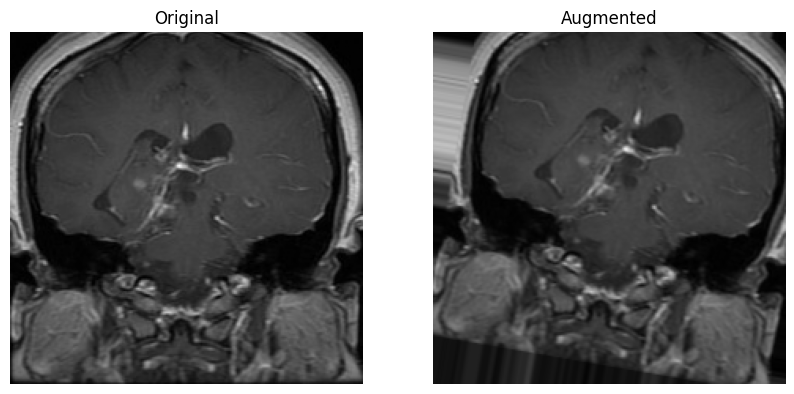

Original image shape: (1, 224, 224, 3)
Original label shape: (1, 4)
Augmented image shape: (1, 224, 224, 3)
Augmented label shape: (1, 4)


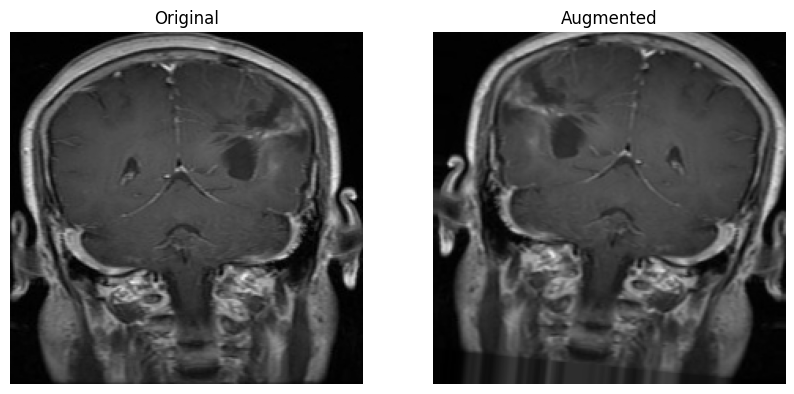

Original image shape: (1, 224, 224, 3)
Original label shape: (1, 4)
Augmented image shape: (1, 224, 224, 3)
Augmented label shape: (1, 4)


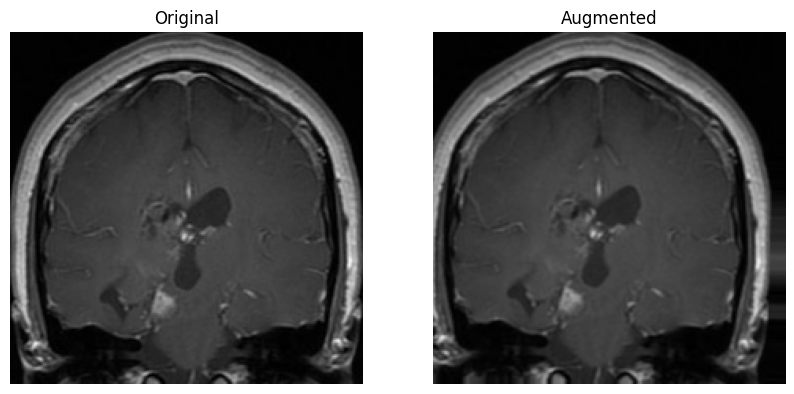

In [32]:
display_augmented_images(datagen, x_train, y_train, num_images=3)

In [33]:
#The shapes will be unchanged because augmented images are created dynamically during the training process.

print(f'Shape of x_train after augmentation: {x_train.shape}')
print(f'Shape of y_train after augmentation: {y_train.shape}')

Shape of x_train after augmentation: (4568, 224, 224, 3)
Shape of y_train after augmentation: (4568, 4)


In [34]:

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import datetime




In [35]:
# Loading the pre-trained ResNet50 model + higher level layers

image_size = 224
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax', dtype='float32')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [36]:
# Compiling the model
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [38]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='min')
#confusion_matrix_callback = LambdaCallback(on_epoch_end=log_confusion_matrix)

In [39]:
callbacks = [early_stopping, reduce_lr]

In [40]:
import io

In [41]:
# Training the model

EPOCHS = 35

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=16),
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


286/286 ━━━━━━━━━━━━━━━━━━━━ 135s 277ms/step - accuracy: 0.8008 - loss: 0.5112 - val_accuracy: 0.2316 - val_loss: 2.9221 - learning_rate: 1.0000e-04
Epoch 2/35
286/286 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.9560 - loss: 0.1374 - val_accuracy: 0.3462 - val_loss: 4.0677 - learning_rate: 1.0000e-04
Epoch 3/35
286/286 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.9606 - loss: 0.1059 - val_accuracy: 0.2963 - val_loss: 5.3504 - learning_rate: 1.0000e-04
Epoch 4/35
286/286 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.9755 - loss: 0.0749 - val_accuracy: 0.9196 - val_loss: 0.3301 - learning_rate: 1.0000e-04
Epoch 5/35
286/286 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.9842 - loss: 0.0467 - val_accuracy: 0.9685 - val_loss: 0.1185 - learning_rate: 1.0000e-04
Epoch 6/35
286/286 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.9834 - loss: 0.0451 - val_accuracy: 0.9659 - val_loss: 0.1243 - learning_rate: 1.0000e-04
Epoch 7/35
286/286 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step -

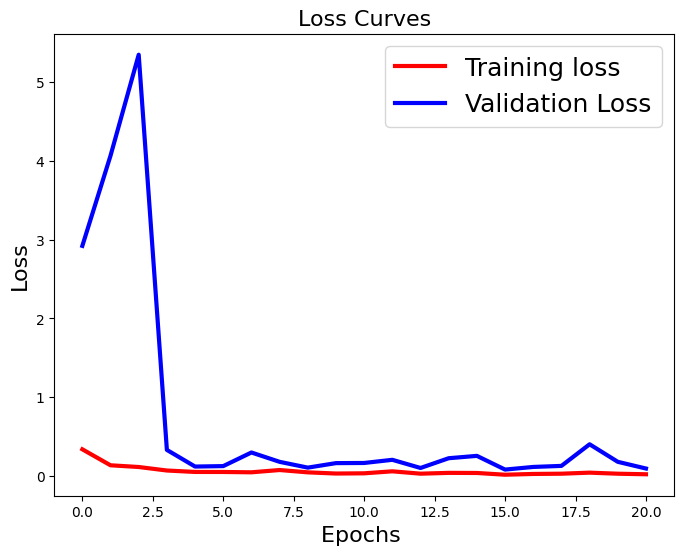

In [42]:
# Plotting the Loss Curves
plt.figure(figsize=[8, 6])
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show()

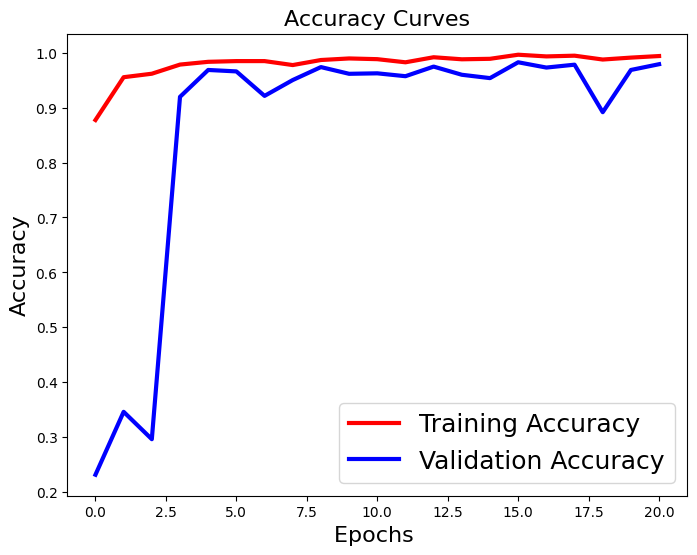

In [43]:
# Plotting the Accuracy Curves
plt.figure(figsize=[8, 6])
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

In [45]:
output_test_dir = '/content/drive/MyDrive/archive/preprocessed_testing'

# Save the test data in batches
save_data_in_batches(output_test_dir, labels, output_test_dir, img_size=(224, 224), batch_size=50)

In [46]:
def load_test_data(data_dir, batch_size=50):
    x_test_list = []
    y_test_list = []

    # Use the same load_data_generator function to load the test batches
    for images, labels in load_data_generator(data_dir, batch_size):
        x_test_list.extend(images)
        y_test_list.extend(labels)

    x_test = np.array(x_test_list)
    y_test = np.array(y_test_list)

    return x_test, y_test

# Load the test data
x_test, y_test = load_test_data(output_test_dir, batch_size=50)

In [47]:
# Predictions
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step


In [48]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.9938977879481312


In [49]:
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f'Test Precision: {precision}')
print(f'Test Recall: {recall}')
print(f'Test F1 Score: {f1}')

Test Precision: 0.9939089993099505
Test Recall: 0.9938977879481312
Test F1 Score: 0.9938997584975243


In [50]:
# Classification Report
class_report = classification_report(true_classes, predicted_classes, target_names=labels)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       300
  meningioma       0.99      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



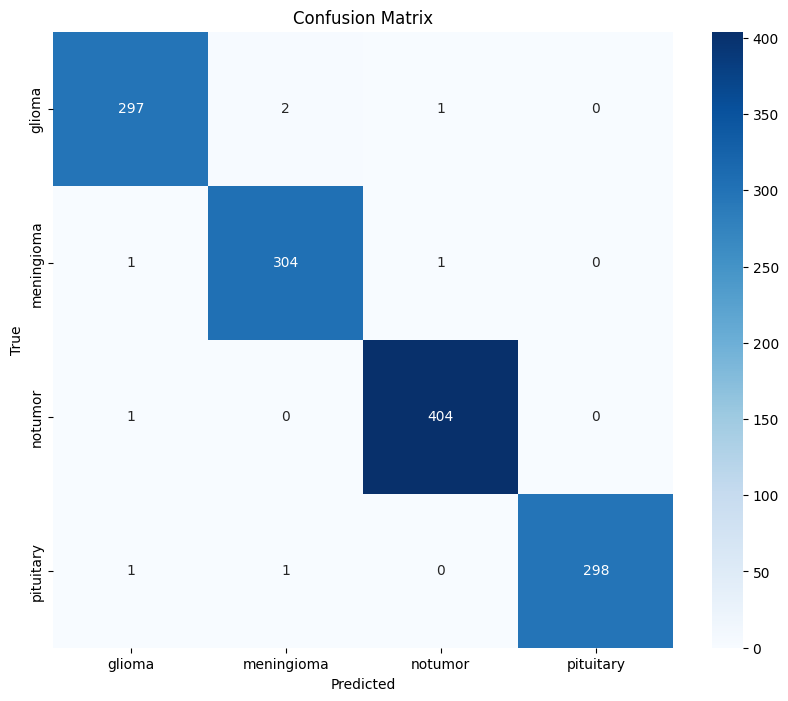

In [51]:
#Plotting the Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [52]:
!pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00


In [57]:
# Assuming 'model' is your trained model
model.save('brain_tumor_model.h5')


In [55]:
!wget -q -O - ipv4.icanhazip.com



34.143.182.108


In [ ]:
!streamlit run /content/drive/MyDrive/app.py & npx localtunnel --port 8501






  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.143.182.108:8501

your url is: https://crazy-mice-speak.loca.lt
2024-08-16 19:29:50.227120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 19:29:50.249205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 19:29:50.255909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 19:29:51.428802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:172383